# 1D Finite-difference simulation of sound in an air column
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.29

_Write a computer program for the 1D (2D) acoustic wave equation following the equations presented in this chapter. Implement the analytical
solution (see Chapter 2) and try to match it with appropriate parameters._

<strong>Scenario: Sound in an air column (p. 85)</strong>
"Suppose we want to simulate acoustic wave propagation in a 10 km column (e.g. the atmosphere) and assume an air sound speed
of c = 343 m/s. We would like to hear the sound wave so it would need a dominant frequency of at least 20 Hz (at the bottom of the audible frequency range).
For the purpose of this exercise we initialize the source time function f(t) using
the first derivative of a Gaussian function (because we are aware that in 1D the
resulting signal is an integral of the source time function and we want a Gaussian
waveform)."

$$s(t) = -Af_0(t-t_0)e^{-\frac{f_0(t-t_0)^2}{(2A)^2}}$$
with dominant frequency $f_0 = 20 Hz$.

Acoustic wave equation (inhomogeneous):
$$\partial_t^2 p(x,t) - c^2 \Delta p(x,t) = s(x,t)$$

If there is an initial pressure field $p(x, t=0) = p_0(x)$, then we can get a solution by iterating over the time elements:
$$p(t+dt) = 2p(t) - p(t-dt) + dt^2[c^2\partial^2_xp + s],$$ where
$d^2_xp(x) = \frac{p(x+dx) - 2p(x) + p(x-dx)}{dx^2}$ (meaning we also need to iterate over x).

<br>
The <strong>analytical solution</strong> is found using
$$p(t) = G(t) * s(t),$$
where 
$$G(t) =
\begin{cases}
    \begin{align}    
        0,            &\quad t \lt \frac{|x|}{c} \\
        \frac{1}{2c}, &\quad t \ge \frac{|x|}{c}
    \end{align}
\end{cases}$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx = 1000     # number of grid points
dx = .5       # distance between grid points
dt = .0012    # time interval
nt = 1000     # number of time steps
c = 343       # wavefield velocity
ixsrc = 100   # x-coord. of source
ixrec = 200   # x-coord. of receiver

x = np.linspace(-nx*dx/2, nx*dx/2, nx)   # space
t = np.arange(0, nt*dt, dt)              # time

# CFL criterion check
eps = c*dt/dx
if eps > 1:
    print('Error: CFL criterion not satisfied! Ensure that c*dt/dx <= 1.')
print(eps)
print(dt*nt, dx*nx)

0.8231999999999999
1.2 500.0


#### Source time function

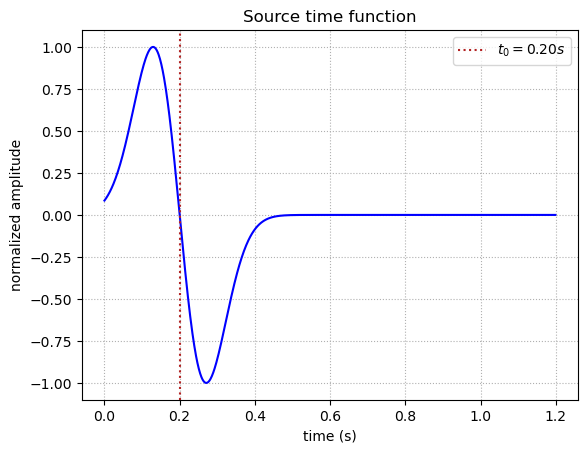

In [3]:
f0 = 20    # dominant frequency (Hz)
t0 = .2    # time shift
A  = 1
src = -A*f0*(t-t0)*np.exp(-((t - t0)*f0 / (2*A))**2)

# normalize the source time function
src /= max(src)

# plot
plt.plot(t, src, 'b')
plt.axvline(t0, linestyle = ':', color = 'firebrick', label = '$t_0 = {:.2f} s$'.format(t0))
plt.xlabel('time (s)')
plt.ylabel('normalized amplitude')
plt.title('Source time function')
plt.legend()
plt.grid(linestyle = ':')

#### Finite-difference calculations

In [4]:
p    = np.zeros(nx)  
pold = np.zeros(nx)
pnew = np.zeros(nx) 
dx2p = np.zeros(nx)   # 2nd derivative in space
seis = np.zeros(nt)


for it in range(nt):

    # calculate partial derivatives (omit boundaries)
    for ix in range(1, nx - 1):
        dx2p[ix] = (p[ix + 1] - 2 * p[ix] + p[ix - 1]) / dx**2
        
    # time extrapolation
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * dx2p

    # add source term at ixsrc
    pnew[ixsrc] = pnew[ixsrc] + dt**2 * src[it] / dx

    # remap time levels
    pold = p
    p = pnew

    # make seismogram
    seis[it] = p[ixrec]


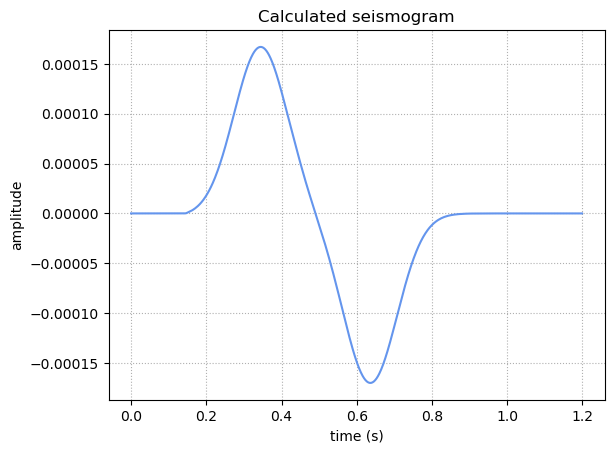

In [5]:
# plot numerical seismogram
plt.plot(t, seis, 'cornflowerblue')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Calculated seismogram')
plt.grid(linestyle = ':')


#### Compare with analytical solution

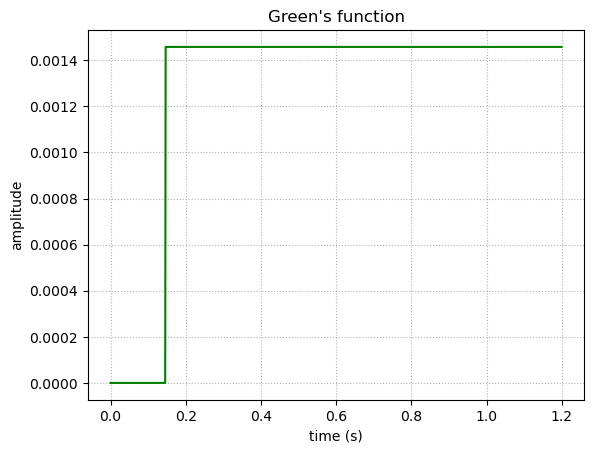

In [6]:
# Green's function:
G = np.zeros(len(t))

for it in range(nt):
    if (t[it] - np.abs(x[ixsrc] - x[ixrec]) / c) >= 0:
        G[it] = 1/(2*c)

plt.plot(t, G, 'g')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Green\'s function')
plt.grid(linestyle = ':')

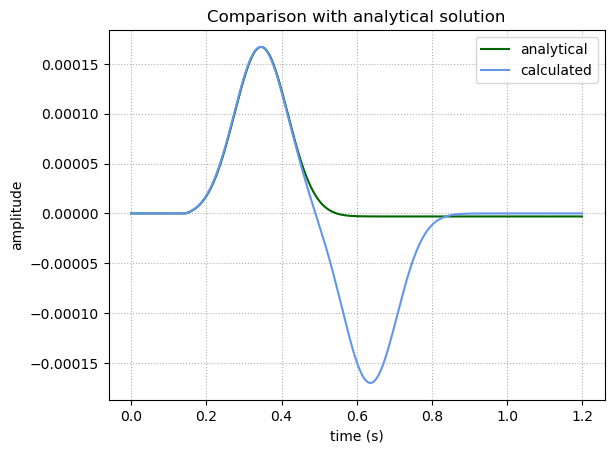

In [7]:
# analytical seismogram:
seis_a = np.convolve(G, src * dt)
seis_a = seis_a[:nt]

# plot to show comparison:
plt.plot(t, seis_a, 'darkgreen', label = 'analytical')
plt.plot(t, seis, 'cornflowerblue', label = 'calculated')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Comparison with analytical solution')
plt.legend()
plt.grid(linestyle = ':')